# 1. Soft SVM with 2 features and 10 samples

In [1]:

from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.utils import shuffle
data = datasets.load_breast_cancer()
from sklearn.preprocessing import StandardScaler

import jax.numpy as jnp
from jax import grad as fgrad
from jax import jit, vmap, jacfwd, jacrev, device_put
import numpy as np
from numpy.linalg import norm
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import grad
from scipy.integrate import solve_ivp
np.set_printoptions(suppress=True)
from matplotlib import pyplot as plt
import random
import jax

from copy import deepcopy

CUDA = torch.cuda.is_available()
mse = nn.MSELoss(reduction='none')
NUMERICAL_METHOD = 'RK45'

seed = 23

random.seed(seed)
# Set seed for NumPy
np.random.seed(seed)
# Set seed for PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
# Set seed for JAX
key = jax.random.PRNGKey(seed)

In [2]:
def select_n_points(data_X, data_y, n):
    # Check if n is even
    if n % 2 != 0:
        raise ValueError("n must be an even number to select equal points from both classes.")

    # Separate the data into two classes: +1 and -1
    class_pos = data_X[data_y == 1]  # Class +1
    class_neg = data_X[data_y == -1]  # Class -1

    # Check if enough points exist in both classes
    if len(class_pos) < n // 2 or len(class_neg) < n // 2:
        raise ValueError("Not enough data points in one or both classes to select n points.")

    # Randomly select n//2 points from each class
    selected_pos = class_pos[np.random.choice(len(class_pos), n // 2, replace=False)]
    selected_neg = class_neg[np.random.choice(len(class_neg), n // 2, replace=False)]

    # Combine the selected points and their labels
    selected_X = np.vstack((selected_pos, selected_neg))
    selected_y = np.hstack((np.ones(n // 2), -np.ones(n // 2)))

    # Shuffle the selected points and labels
    selected_X, selected_y = shuffle(selected_X, selected_y, random_state=42)

    return selected_X, selected_y

In [3]:
X = data.data 
y = data.target
feature_names = data.feature_names

X = pd.DataFrame(X, columns=feature_names) 
# Select only the desired features
data_X = X[['mean radius', 'mean concave points']].to_numpy()

# Encode y to be +1 and -1
le = LabelEncoder()
data_y = le.fit_transform(y)
data_y[data_y == 0] = -1  # Replace 0 with -1

[Text(0.5, 0, 'mean radius'), Text(0, 0.5, 'mean concave points')]

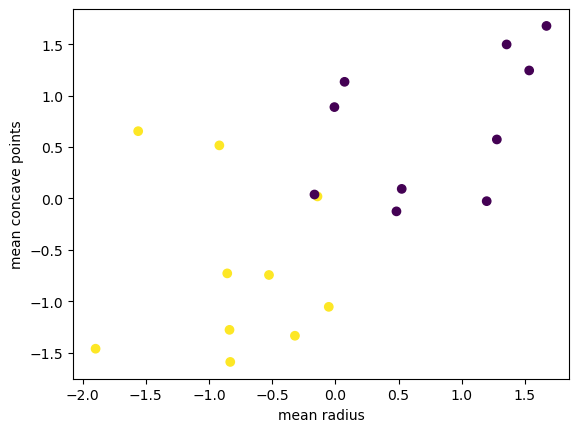

In [4]:
n = 20
selected_X, selected_y = select_n_points(data_X, data_y, n)
scaler = StandardScaler()
selected_X = scaler.fit_transform(selected_X)
_, ax = plt.subplots()
scatter = ax.scatter(selected_X[:, 0], selected_X[:, 1], c=selected_y)
ax.set(xlabel='mean radius', ylabel='mean concave points')

In [5]:
# Define the plotting function
def plot_svm_decision_boundary(X, y, w, b, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Iris versicolor')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Iris setosa')

    # Plot decision boundary
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Use only the selected features for the decision boundary
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = np.dot(grid, w[[feature_x_idx, feature_y_idx]]) + b
    Z = Z.reshape(xx.shape)
    
    plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])
    
    plt.xlabel(f'mean radius')
    plt.ylabel(f'mean concave points')
    plt.legend()
    plt.title('Soft Margin SVM Decision Boundary')
    plt.show()
    
# Define the modified plotting function to plot two decision boundaries
def plot_svm_decision_boundary_confrontation(X, y, w_1, b_1, w_2, b_2, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Iris versicolor')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Iris setosa')

    # Create mesh grid for decision boundaries
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # First model's decision boundary (Ground Truth) in orange with highlight effect (thicker and transparent)
    Z1 = np.dot(grid, w_1[[feature_x_idx, feature_y_idx]]) + b_1
    Z1 = Z1.reshape(xx.shape)
    ground_truth = plt.contour(xx, yy, Z1, colors='purple', levels=[0], alpha=0.3, linewidths=5, linestyles=['-'])
    plt.contour(xx, yy, Z1, colors='purple', levels=[-1, 1], alpha=0.3, linewidths=3, linestyles=['--'])
    
    # Second model's decision boundary (ODE Solution) in purple
    Z2 = np.dot(grid, w_2[[feature_x_idx, feature_y_idx]]) + b_2
    Z2 = Z2.reshape(xx.shape)
    ode_solution = plt.contour(xx, yy, Z2, colors='green', levels=[0], alpha=0.8, linewidths=2, linestyles=['-'])
    plt.contour(xx, yy, Z2, colors='green', levels=[-1, 1], alpha=0.8, linewidths=1.5, linestyles=['--'])
    
    # Add the two main lines to the legend
    h1, _ = ground_truth.legend_elements()
    h2, _ = ode_solution.legend_elements()
    legend_elements = [h1[0], h2[0], 
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10)]
    legend_labels = ['Ground Truth', 'ODE Solution', 'Iris versicolor', 'Iris setosa']
    plt.legend(legend_elements, legend_labels, loc='upper right')
    
    # Add labels, title, and show the plot
    plt.xlabel(f'mean radius')
    plt.ylabel(f'mean concave points')
    plt.title('SVM Decision Boundaries')
    plt.show()

In [6]:
def adjust_label_positions(positions, min_distance=0.02):
    """Adjust vertical positions of labels to avoid overlap."""
    sorted_positions = sorted(enumerate(positions), key=lambda x: x[1])
    adjusted_positions = positions.copy()
    
    for i in range(1, len(sorted_positions)):
        curr_idx, curr_pos = sorted_positions[i]
        prev_idx, prev_pos = sorted_positions[i-1]
        
        if curr_pos - prev_pos < min_distance:
            adjusted_positions[curr_idx] = prev_pos + min_distance
    
    return adjusted_positions

def plot_ode_system(t_values, y_values):
    plt.figure(figsize=(8, 6))
    # Enable LaTeX rendering
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Plot each line and prepare label information
    labels = [f'a_{i}' for i in range(1,nx+1)]
    colors = plt.cm.rainbow(np.linspace(0, 1, len(labels)))
    label_positions = []

    for i, (label, color) in enumerate(zip(labels, colors)):
        line = plt.plot(t_values, y_values[i, :], label=label, color=color)[0]
        label_positions.append(y_values[i, -1])

    # Adjust label positions
    y_min, y_max = np.min(y_values), np.max(y_values)
    y_range = y_max - y_min
    min_distance = 0.02 * y_range  # 2% of y-range as minimum distance
    adjusted_positions = adjust_label_positions(label_positions, min_distance)

    # Add adjusted labels with increased font size and space
    fontsize = 14  # Adjust the font size here
    x_offset = 1  # Space to move the label away from the line
    
    for i, (label, color, position) in enumerate(zip(labels, colors, adjusted_positions)):
        math_label = f"${label}$"  # Add space with LaTeX's \quad
        x_end = t_values[-1]
        plt.text(x_end + x_offset, position, f' {math_label}', verticalalignment='center', 
                 horizontalalignment='left', color=color, fontsize=fontsize)

    plt.xlabel('Time', fontsize=fontsize)
    plt.ylabel('y(t)', fontsize=fontsize)
    plt.title('ODE System Solution', fontsize=fontsize)
    plt.grid(False)

    # Adjust the plot limits to make room for labels
    plt.xlim(t_values[0], t_values[-1] * 1.1)  # Extend x-axis by 10%
    #plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)  # Extend y-axis by 10% on both ends

    plt.tight_layout()
    plt.show()

Matrix G is not PSD, regularizing...
Time: 0.018386363983154297
Optimal objective value: -22.634427133366817
SCS solver iterations: 250
SCS solve time: 0.001891705
SCS setup time: 0.001801576
Weight vector w: [-1.90878758 -1.05297309]
Bias term b: -0.20938633058349973
Optimal value: -22.6344
Number of support vectors: 3
Dual variables (alpha): [-0.          2.50532156  0.         -0.         -0.          1.57592359
 -0.         10.         10.          0.          0.          0.
  0.92939798  0.00000001 -0.         -0.         -0.          0.
 -0.          0.        ]
Constraints: [  0.          -2.5053215   -0.           0.           0.
  -1.5759236    0.         -10.         -10.          -0.
  -0.          -0.          -0.929398    -0.00000001   0.
   0.           0.          -0.           0.          -0.
 -10.          -7.4946785  -10.         -10.         -10.
  -8.424076   -10.           0.          -0.         -10.
 -10.         -10.          -9.070602   -10.         -10.
 -10. 

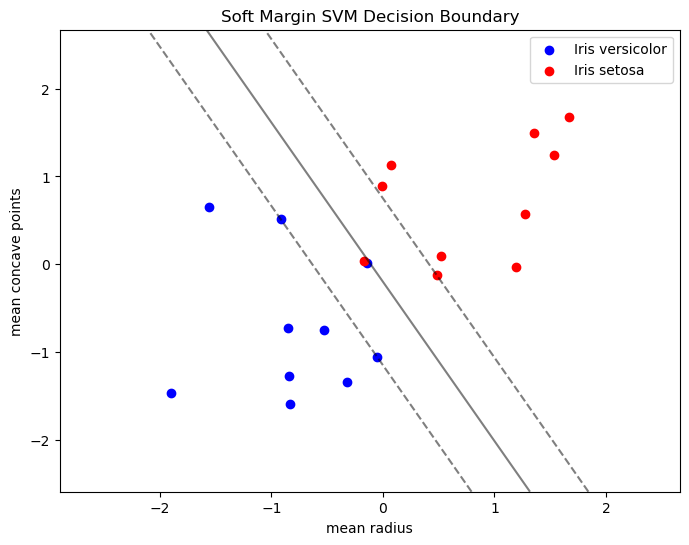

In [7]:
import cvxpy as cp
import numpy as np
import time

C = 10

num_samples = selected_X.shape[0]
num_features = selected_X.shape[1]


# Define the dual variables
alpha = cp.Variable(num_samples)

# Kernel matrix (for linear kernel, it's just dot product of features)
K = selected_X @ selected_X.T

G = np.outer(selected_y, selected_y) * K # G_ij = y_i y_j K(x_i, x_j)

eigvals = np.linalg.eigvals(G)

if np.any(eigvals < 0):
    print("Matrix G is not PSD, regularizing...")
    G += np.eye(num_samples) * 1e-6 
    

objective = cp.Minimize((1/2) * cp.quad_form(alpha, G) - cp.sum(alpha))

# Define the constraints
constraints = [
    selected_y.T @ alpha == 0,
    alpha >= 0,
    alpha <= C
]

problem = cp.Problem(objective, constraints)

t0 = time.time()
problem.solve(solver='SCS')
solve_time = time.time() - t0

# Get solver stats
solver_stats = problem.solver_stats
print('Time:', solve_time)
print('Optimal objective value:', problem.value)
print('SCS solver iterations:', solver_stats.num_iters)
print('SCS solve time:', solver_stats.solve_time)
print('SCS setup time:', solver_stats.setup_time)

def alpha_to_wb(alpha, X, y, epsilon=1e-3):
    w = np.sum(alpha.reshape(-1, 1) * y.reshape(-1, 1) * X, axis=0)

    # Find support vectors (points where 0 < alpha < C)
    support_vector_indices = np.where((alpha > epsilon) & (alpha < C - epsilon))[0]
    n_support_vectors = len(support_vector_indices)
    
    if len(support_vector_indices) == 0:
        raise ValueError("No support vectors found. Try adjusting epsilon.")
    
    # Calculate b using the average over all support vectors
    b = 0
    for i in support_vector_indices:
        b += y[i] - np.dot(w, X[i])
    
    b /= len(support_vector_indices)
    
    return w, b, n_support_vectors
    
w_op, b_op, sv_op = alpha_to_wb(alpha.value, selected_X, selected_y)

print(f"Weight vector w: {w_op}")
print(f"Bias term b: {b_op}")

print(f"Optimal value: {problem.value:.4f}")
print(f"Number of support vectors: {np.sum(sv_op)}")

print('Dual variables (alpha):', alpha.value)

g_1 = jnp.array([-alpha.value[i] for i in range(alpha.value.shape[0])])
g_2 = jnp.array([alpha.value[i] - C for i in range(alpha.value.shape[0])])

g_1 = g_1.reshape(-1, 1)
g_2 = g_2.reshape(-1, 1)
g = jnp.concatenate([g_1, g_2])
g_SCS = g.flatten()
print('Constraints:', g_SCS)
alpha_SCS = alpha.value

# Plotting
plot_svm_decision_boundary(selected_X, selected_y, w_op, b_op, 0, 1)

In [8]:
nx = num_samples
nu = num_samples * 2
nw = num_features
NY = nx + nu


A = jnp.array(selected_y.reshape(-1, 1).T)
b = jnp.zeros(1)

In [9]:
PM = A.T@jnp.linalg.inv(A@A.T)@A

def f(x):
    output = (1/2) * x.T @ G @ x - jnp.sum(x)
    return output

def g(x):    
    g_1 = [- x[i] for i in range(selected_y.shape[0])]
    g_2 = [x[i] - C for i in range(selected_y.shape[0])]
    output = jnp.array(g_1 + g_2)
    return output

def h(x):
    output = jnp.clip(A@x-b, a_min=-1, a_max=1)

    return output

df = fgrad(f) # jacobian of f
dg = jacrev(g) # jacobian of g

def P(xu): # projection mapping
    x, u = xu[:nx].reshape((nx,)), xu[nx:].reshape((nu,))
    x = x - (A.T@jnp.linalg.inv(A@A.T))@((A@x-b).reshape((-1, )))
    u = np.clip(u, a_min=0, a_max=None)
    output = np.concatenate([x, u], axis=0)
    return output

def ODE(t, xu):
    x, u = xu[:nx].reshape((nx, )), xu[nx:].reshape((nu, ))

    dx = df(x) + dg(x).T@jnp.clip(u+g(x), a_min=0)
    dx = -(jnp.identity(nx) - PM)@dx - A.T@h(x)
    du = -u + jnp.clip(u+g(x), a_min=0)
    du = 0.5*du
    dxu = jnp.concatenate([dx, du], axis=0)
    return dxu

ODE = jit(ODE)

def evalutation(xu): # metric OuC(x_pred): check if inisde feasable region and return the objective value
    "return  f(x),    if g(x)<=0, f(x)=np.inf, if g(x)>0 "
    x, u= xu[:nx], xu[nx:]
    if (g(x)<=0.001).all():
        obj = f(x)
        #print('g(x) values:', g(x))
    else:
        obj = np.inf
        #print('g(x) values:', g(x))
    return obj

def constraints_diff(g_ODE, g_SCS):
    return jnp.abs(g_ODE - g_SCS)

In [10]:
def solve_ODE(xuv0, T):
    sol = solve_ivp(ODE, [0., T], xuv0, method=NUMERICAL_METHOD)
    result = P(sol.y[:, -1])
    print("objective:",evalutation(result))
    print("Dual variables (alpha):", result[:nx])
    diff = constraints_diff(result[:nx], alpha_SCS)
    print("max diff:", diff.max(), "mean diff:", diff.mean())
    print("Constraints:",g(result[:nx]))
    
    return sol, result

objective: -22.62893
Dual variables (alpha): [ 0.00006548  2.50210571  0.00008607  0.00009183  0.0001317   1.57361507
  0.00012468  9.99997616 10.00002289  0.00025731  0.00018577  0.00023573
  0.92916566  0.0001344   0.00015432  0.00009959  0.00009249  0.00030121
  0.00026085  0.00005009]
max diff: 0.003215849 mean diff: 0.00040374725
Constraints: [ -0.00006548  -2.5021057   -0.00008607  -0.00009183  -0.0001317
  -1.5736151   -0.00012468  -9.999976   -10.000023    -0.00025731
  -0.00018577  -0.00023573  -0.92916566  -0.0001344   -0.00015432
  -0.00009959  -0.00009249  -0.00030121  -0.00026085  -0.00005009
  -9.999934    -7.4978943   -9.999914    -9.999908    -9.999868
  -8.426385    -9.999875    -0.00002384   0.00002289  -9.9997425
  -9.999814    -9.999764    -9.070834    -9.999866    -9.9998455
  -9.999901    -9.9999075   -9.999699    -9.999739    -9.999949  ]
max diff: 0.0032157898 mean diff: 0.0004037648


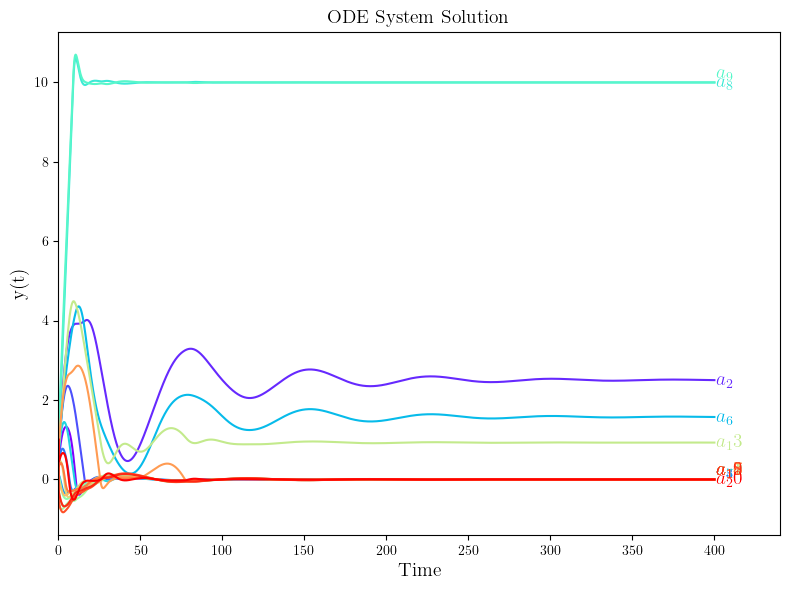

Weight vector w: [-1.90950251 -1.05358592]
Bias term b: -0.20963785708878693
Number of support vectors: 3


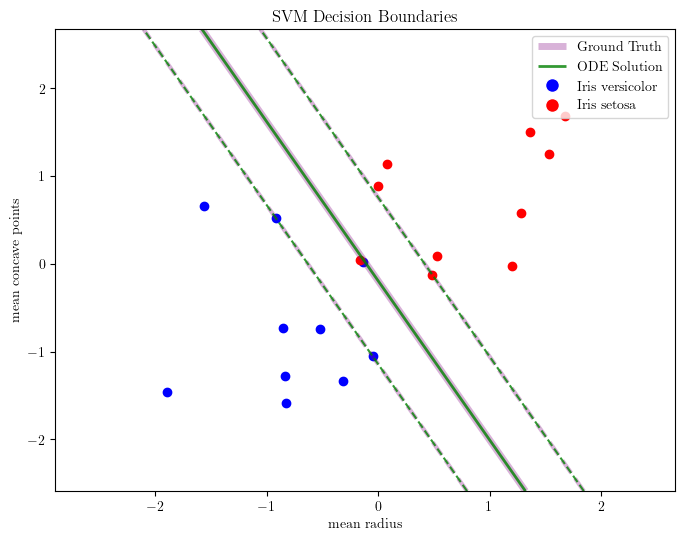

In [17]:
xu0 = jnp.zeros(NY)
xu0 = xu0.at[:nx].set(1.0)

sol, result = solve_ODE(xu0, 400)

t_values = sol.t
y_values = sol.y

plot_ode_system(t_values, y_values)

alpha_ode = result[:nx]
w_ode, b_ode, sv_ode = alpha_to_wb(alpha_ode, selected_X, selected_y)
print(f"Weight vector w: {w_ode}")
print(f"Bias term b: {b_ode}")
print(f"Number of support vectors: {np.sum(sv_ode)}")

plot_svm_decision_boundary_confrontation(selected_X, selected_y, w_op, b_op, w_ode, b_ode, 0, 1)

In [12]:
t0 = time.time()
sol, result = solve_ODE(xu0, 20)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: inf
Dual variables (alpha): [-0.01426288  3.88564372 -0.14307375 -0.0296374  -0.05874022  2.54944968
 -0.07795864 10.02338123  9.96653175 -0.17337918 -0.13424566 -0.12903051
  2.34393525 -0.10828296 -0.06941125  1.69448555 -0.04049997 -0.19693922
 -0.17158206 -0.03398409]
max diff: 1.6944855 mean diff: 0.34503743
Constraints: [  0.01426288  -3.8856437    0.14307375   0.0296374    0.05874022
  -2.5494497    0.07795864 -10.023381    -9.966532     0.17337918
   0.13424566   0.12903051  -2.3439353    0.10828296   0.06941125
  -1.6944855    0.04049997   0.19693922   0.17158206   0.03398409
 -10.014263    -6.114356   -10.143074   -10.029637   -10.058741
  -7.45055    -10.077959     0.02338123  -0.03346825 -10.173379
 -10.134246   -10.12903     -7.656065   -10.108283   -10.069411
  -8.305514   -10.0405     -10.196939   -10.171582   -10.033984  ]
max diff: 1.6944857 mean diff: 0.34503746
Time: 1.7364137172698975


In [13]:
t0 = time.time()
sol, result = solve_ODE(xu0, 50)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: -20.688343
Dual variables (alpha): [ 0.02951778  0.8956998   0.02494219  0.03572527  0.05207096  0.33394071
  0.03279623  9.99938679 10.00021839  0.08500525  0.06130935  0.09225389
  0.70019358  0.04517191  0.05883462  0.04680609  0.0404151   0.09933852
  0.08457809  0.03352693]
max diff: 1.6096218 mean diff: 0.19519663
Constraints: [ -0.02951778  -0.8956998   -0.02494219  -0.03572527  -0.05207096
  -0.3339407   -0.03279623  -9.999387   -10.000218    -0.08500525
  -0.06130935  -0.09225389  -0.7001936   -0.04517191  -0.05883462
  -0.04680609  -0.0404151   -0.09933852  -0.08457809  -0.03352693
  -9.970482    -9.1043005   -9.975058    -9.964274    -9.947929
  -9.6660595   -9.967204    -0.00061321   0.00021839  -9.914995
  -9.93869     -9.907746    -9.299807    -9.954828    -9.941165
  -9.953194    -9.959585    -9.900661    -9.9154215   -9.966473  ]
max diff: 1.609622 mean diff: 0.19519667
Time: 3.5970704555511475


In [14]:
t0 = time.time()
sol, result = solve_ODE(xu0, 100)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: inf
Dual variables (alpha): [-0.0001282   2.50105262  0.00301774  0.00049257  0.0011783   1.58933496
  0.00397592  9.99809647 10.00189781  0.00633893  0.00490111  0.00305507
  0.94892961  0.00383786  0.00165948  0.00347074  0.00034214  0.00722441
  0.00646889 -0.00077452]
max diff: 0.019531632 mean diff: 0.004393958
Constraints: [  0.0001282   -2.5010526   -0.00301774  -0.00049257  -0.0011783
  -1.589335    -0.00397592  -9.998096   -10.001898    -0.00633893
  -0.00490111  -0.00305507  -0.9489296   -0.00383786  -0.00165948
  -0.00347074  -0.00034214  -0.00722441  -0.00646889   0.00077452
 -10.000128    -7.498947    -9.996983    -9.999508    -9.998821
  -8.4106655   -9.996024    -0.00190353   0.00189781  -9.993661
  -9.995099    -9.996945    -9.05107     -9.996162    -9.998341
  -9.99653     -9.999658    -9.992776    -9.993531   -10.000774  ]
max diff: 0.019532204 mean diff: 0.0043938863
Time: 7.3939220905303955


In [15]:
t0 = time.time()
sol, result = solve_ODE(xu0, 500)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: -22.633722
Dual variables (alpha): [ 0.00000878  2.50452089  0.00001066  0.00001196  0.00001736  1.57531464
  0.00001532  9.99999714 10.00000286  0.00003243  0.0000235   0.0000306
  0.92928588  0.00001692  0.00001999  0.00001211  0.00001234  0.00003793
  0.00003298  0.00000721]
max diff: 0.0008006687 mean diff: 9.087598e-05
Constraints: [ -0.00000878  -2.504521    -0.00001066  -0.00001196  -0.00001736
  -1.5753146   -0.00001532  -9.999997   -10.000003    -0.00003243
  -0.0000235   -0.0000306   -0.9292859   -0.00001692  -0.00001999
  -0.00001211  -0.00001234  -0.00003793  -0.00003298  -0.00000721
  -9.999991    -7.495479    -9.9999895   -9.999988    -9.999983
  -8.4246855   -9.999985    -0.00000286   0.00000286  -9.999968
  -9.999976    -9.9999695   -9.070714    -9.999983    -9.99998
  -9.999988    -9.999988    -9.999962    -9.999967    -9.999992  ]
max diff: 0.0008006096 mean diff: 9.091467e-05
Time: 34.8503053188324


In [17]:
t0 = time.time()
sol, result = solve_ODE(xu0, 1000)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: -22.634409
Dual variables (alpha): [ 0.00000022  2.50532079  0.00000013  0.00000029  0.00000039  1.57592309
  0.00000031 10.         10.          0.0000006   0.00000049  0.0000007
  0.929398    0.00000032  0.00000043  0.00000028  0.00000034  0.00000052
  0.00000066  0.00000021]
Constraints: [ -0.00000022  -2.5053208   -0.00000013  -0.00000029  -0.00000039
  -1.5759231   -0.00000031 -10.         -10.          -0.0000006
  -0.00000049  -0.0000007   -0.929398    -0.00000032  -0.00000043
  -0.00000028  -0.00000034  -0.00000052  -0.00000066  -0.00000021
 -10.          -7.4946795  -10.         -10.         -10.
  -8.424077   -10.           0.           0.          -9.999999
  -9.999999    -9.999999    -9.070602   -10.         -10.
 -10.         -10.          -9.999999    -9.999999   -10.        ]
max diff: 9.536743e-07 mean diff: 9.536743e-07
Time: 91.86211824417114


In [ ]:
alpha_ode = result[:nx]
w_ode, b_ode, sv_ode = alpha_to_wb(alpha_ode, selected_X, selected_y)

# 3. The method

In [18]:
T=400.0

In [19]:
class FNN(nn.Module):
    def __init__(self, y0):
        self.y0 = torch.tensor(y0, dtype=torch.float)
        if CUDA:
            self.y0 = self.y0.cuda()
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(1, NEURONS).cuda()
        self.linearL = []
        for _ in range(LAYERS-1):
            self.linearL.append(nn.Linear(NEURONS, NEURONS).cuda())
        self.linear2 = nn.Linear(NEURONS, NY).cuda()

    def forward(self, x):
        t = x.cuda()
        x = torch.tanh(self.linear1(x))
        for i in range(LAYERS-1):
            x = torch.tanh(self.linearL[i](x))
        x = self.linear2(x)
        x = self.y0 + (1 - torch.exp(-(t-0)))*x
        return x


class NN_NOP:
    def __init__(self, y0, time_range, P, ODE, C_epsilon): # P: projection mapping, ODE, C_epsilon: OuC metric
        self.y0 = np.array(y0)
        self.time_range = time_range # [0, 10]
        self.T = time_range[-1] # T=10
        self.P = P
        self.ODE = ODE
        self.C_epsilon = C_epsilon
        self.vODE = vmap(ODE, in_axes=(0, 0), out_axes=0)
        #self.numerical_method() # solve analyicallly the ODE

    def numerical_method(self):
        sol = solve_ivp(self.ODE, self.time_range, self.y0, method=NUMERICAL_METHOD)
        self.y_T_ODE = sol.y[:, -1] # get last value of the solution
        self.y_T_ODE = self.P(self.y_T_ODE) # project it
        self.y_T_ODE = np.array(self.y_T_ODE)
        self.epsilon_ODE = self.C_epsilon(self.y_T_ODE) # calculate OuC (f(x))

    def NN_method(self, weights=None, t_L=None):
        """
        train the nn, store the following four

        L_loss:  list, loss of batch during training
        L_epsilon: list, epsilon_best during training
        L_y_T: list, yT during training
        net_best:  the best neural network model during training
        """
        net = FNN(self.y0)
        if weights is not None:
            net.load_state_dict(weights.state_dict())
        if CUDA:
            net = net.cuda()
            
        optimizer = Adam(net.parameters(), lr=LR) # ========> 0.001 not looks good
        i = 0
        L_loss = []
        L_epsilon = []
        L_epsilon_curr = []
        L_y_T = []
        L_y_T_curr = []
        #L_y_iterations = []
        t0 = time.time()
        while True:
            # Update, L_epsilon, L_yT, net_best
            T = self.T*torch.ones((1, 1), dtype=torch.float)
            if CUDA:
                T = T.cuda()
            y_T = self.P_multiple(T, net) # get the output of the nn at T (last time)
            L_y_T_curr.append(y_T)

            epsilon_current = self.C_epsilon(y_T) # calculate OuC (f(x))
            L_epsilon_curr.append(epsilon_current)
            if i==0: # if first iteration
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
                #L_y_iterations.append(self.y_iteration(net_best))
            # if i==10:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==20:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==ITERATIONS-1:
            #L_y_iterations.append(self.y_iteration(net_best)) # store the output of the best nn across the time
            if epsilon_current < epsilon_best:
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
            L_epsilon.append(epsilon_best) # store the best OuC
            L_y_T.append(y_T_best) # store the best output of the nn at T

            # TRAIN MODEL
            # Prepare input t, torch.tensor (NBATCH, 1)
            if t_L is not None:
                t = t_L[i]
            else:
                t = np.random.uniform(0, self.T, (NBATCH, 1))
            t = torch.tensor(t, dtype=torch.float, requires_grad=True)
            if CUDA:
                t = t.cuda()
            # Learning, L_loss
            loss = self.loss_compute(t, net)
            loss.backward()
            L_loss.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()
            # Monitor
            if i%100==0:
            # if i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                #print(f'T: {self.T}, y_T_ODE: {self.y_T_ODE.round(4)}, epsilon_ODE: {self.epsilon_ODE :.4f},  Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}, ||y_T_ODE-y_T_best||_2: {y_T_error :.4f}')
                #print(f'T: {self.T}, Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}')
                pass
            i = i+1
            
            torch.cuda.empty_cache()
            
            if i==ITERATIONS:
                break

        return L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time.time()-t0

    def loss_compute(self, t, net):
        # nn output xu, torch.tensor (NBATCH, nxu)
        y = net(t)

        # => Get ODE derivatives
        # True dxu, torch.tensor (NBATCH, nxu)
        t_cpu = t.cpu().detach().numpy()
        y_cpu = y[:, :].cpu().detach().numpy()
        dy = self.vODE(t_cpu, y_cpu)
        dy = np.array(dy)
        
        dy = torch.tensor(dy, dtype=torch.float)
        if CUDA:
            dy = dy.cuda()

        # => Get NN derivatives (autograd)
        # Predicted pdxu, torch.tensor (NBATCH, nxu)
        pdy = []
        for j in range(NY): # for all outputs node (for all variables)
            # y[:, [j]]: outputs of the nn for the j-th variable (all t of the batch), t: inputs of the nn, grad_outputs: scale the gradients to facilitate the compuation of the jacobian, Craete_graph: to compute higer order derivatives
            pdyi = grad(y[:, [j]], t, grad_outputs=torch.ones_like(y[:, [j]]), create_graph=True)[0] # torch autograd shape [NBATCH, 1]
            pdy.append(pdyi)
        pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]
        #pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]

        # Compute loss, torch.tensor a float
        dynamics_loss = mse(dy, pdy) # [NBATCH, NY]
        dynamics_loss = torch.sum(dynamics_loss, axis=1) # [NBATCH]
        dynamics_loss = torch.exp(-WEIGTHING*(t / T).detach().reshape((-1, )))*dynamics_loss  # proprity smaller t
        dynamics_loss = torch.mean(dynamics_loss, axis=0)
        
        return dynamics_loss

    def P_multiple(self, t, net): # get the projection of the output of the nn (for multiple t)
        y = net(t)
        y = y.reshape((-1, )).cpu().detach().numpy()
        output = self.P(y)
        output = np.array(output)
        return output

    def y_iteration(self, net): # get the ODE system estiamtion across the time
        # For L_y
        t = torch.arange(0, self.T, 0.1).reshape((-1, 1))
        if CUDA:
            t = t.cuda()
        y = [self.P_multiple(t[i].reshape((1,1)), net) for i in range(t.shape[0])]
        y = torch.tensor(np.array(y)).cpu().detach().numpy()

        return y # [T, NY]


In [20]:
y0 = np.zeros(NY)
y0[:nx] = 1.0

In [21]:
def try_layers(l_list, n, lr):
     NEURONS = n
     LR = lr
     res = []
     for l in l_list:
          LAYERS = l
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time})
     return res

def try_neurons(n_list, l, lr):
     LAYERS = l
     LR = lr
     res = []
     for n in n_list:
          NEURONS = n
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time})
     return res

def try_lr(lr_list, l, n):
     LAYERS = l
     NEURONS = n
     res = []
     for lr in lr_list:
          LR = lr
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time})
     return res

def plot_results(res, y_max=50):
    fig, axes = plt.subplots(1, len(res), figsize=(20, 6))
    y_min = 0
    for i in range(len(res)):
        # Plot on the first subplot
        axes[i].plot(res[i]['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
        axes[i].plot(res[i]['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
        axes[i].set_xlabel('iteration')
        axes[i].set_ylabel('OuC metric')
        axes[i].set_title(f'l={res[i]["layers"]}, n={res[i]["neurons"]}, lr={res[i]["lr"]}')
        axes[i].legend()
        axes[i].grid(True)
        axes[i].set_ylim(y_min, y_max)
        axes[i].set_xlim(0, ITERATIONS)
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    # Show the plot
    plt.show()

def plot_result_confrontation(res):
     plt.figure(figsize=(6, 5))
     for r in res:
          plt.plot(r['L_epsilon'], marker='o', linestyle='-', label=f'l={r["layers"]}, n={r["neurons"]}, lr={r["lr"]}', markersize=1)
     # Add labels, title, legend and grid
     plt.xlabel('iteration')
     plt.ylabel('OuC metric')
     plt.title('Numbers of layers')
     plt.legend()  # Show the legend to distinguish the datasets
     plt.grid(False)
     plt.show()

def plot_hyperplane(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]]).cuda()).cpu().detach().numpy()
     w_net = epsilon[0][:selected_X.shape[1]]
     b_net = epsilon[0][selected_X.shape[1]]
     # Plotting
     plt.figure(figsize=(10, 8))
     plt.scatter(selected_X[selected_y > 0][:, 0], selected_X[selected_y > 0][:, 1], c='b', label='Class 1')
     plt.scatter(selected_X[selected_y < 0][:, 0], selected_X[selected_y < 0][:, 1], c='r', label='Class -1')

     # Plot the decision boundary
     x_min, x_max = selected_X[:, 0].min() - 1, selected_X[:, 0].max() + 1
     y_min, y_max = selected_X[:, 1].min() - 1, selected_X[:, 1].max() + 1
     xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
     Z = np.dot(np.c_[xx.ravel(), yy.ravel()], w_net) + b_net
     Z = Z.reshape(xx.shape)
     plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])

     # Plot the margins
     plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])

     plt.xlabel('Feature 1')
     plt.ylabel('Feature 2')
     plt.legend()
     plt.title('Hard Margin SVM Decision Boundary')
     plt.show()

def get_error(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]], dtype=torch.float32).cuda()).cpu().detach().numpy()
     # Split epsilon into weights and bias
     alpha_net = epsilon[0][:nx]  # All weights

     # Calculate absolute differences for weights and bias
     alpha_abs_diff = np.abs(alpha_ode - alpha_net)

     # Calculate squared differences
     alpha_sq_diff = alpha_abs_diff ** 2               # Vector for squared differences of weights           # Squared difference for bias

     # Calculate the Mean Squared Error (MSE)
     mse_ = np.mean(alpha_sq_diff)

     return mse_

LAYERS: 1 NEURONS: 100 LR: 0.01 epsilon: 169.9714 MSE solution: 8.889528420177104 time: 149.96651601791382
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 28.741566 MSE solution: 8.318982233015927 time: 145.9596028327942
LAYERS: 3 NEURONS: 100 LR: 0.01 epsilon: 86.16792 MSE solution: 8.657439825961813 time: 156.03080534934998
LAYERS: 4 NEURONS: 100 LR: 0.01 epsilon: 72.4861 MSE solution: 8.78369747738807 time: 149.90577340126038
LAYERS: 5 NEURONS: 100 LR: 0.01 epsilon: 65.39253 MSE solution: 4.66810147014287 time: 153.99388647079468


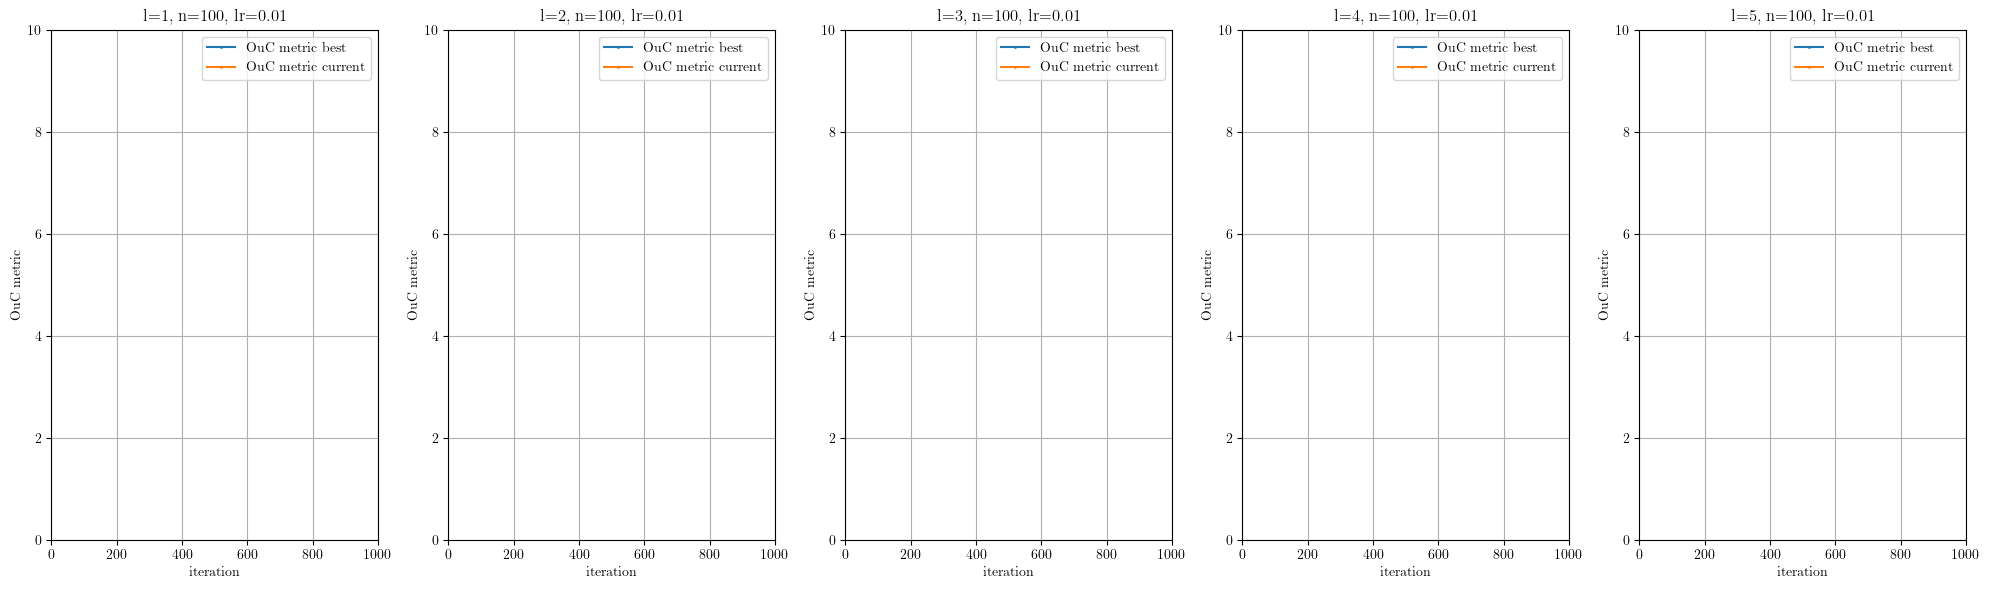

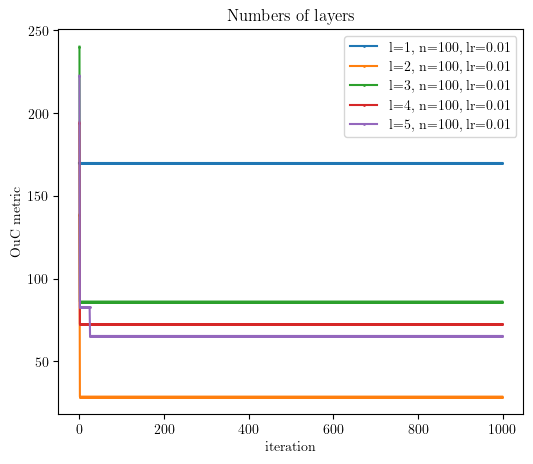

In [24]:
T=400.0
NBATCH = 512
ITERATIONS = 1000
WEIGTHING = 5
NEURONS=100
LR=0.01
LAYERS=2
res_layers = try_layers([1, 2, 3, 4, 5], 100, 0.01)
plot_results(res_layers, y_max=10)
plot_result_confrontation(res_layers)

LAYERS: 2 NEURONS: 50 LR: 0.01 epsilon: 28.0265 MSE solution: 8.332418767157185 time: 138.15866470336914
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 95.59289 MSE solution: 8.662346959747486 time: 137.3678686618805
LAYERS: 2 NEURONS: 200 LR: 0.01 epsilon: 72.20476 MSE solution: 8.797932193079584 time: 136.9850652217865
LAYERS: 2 NEURONS: 300 LR: 0.01 epsilon: 54.41447 MSE solution: 4.759639671139903 time: 137.6598892211914
LAYERS: 2 NEURONS: 400 LR: 0.01 epsilon: 88.57755 MSE solution: 9.28557258009064 time: 136.2493736743927


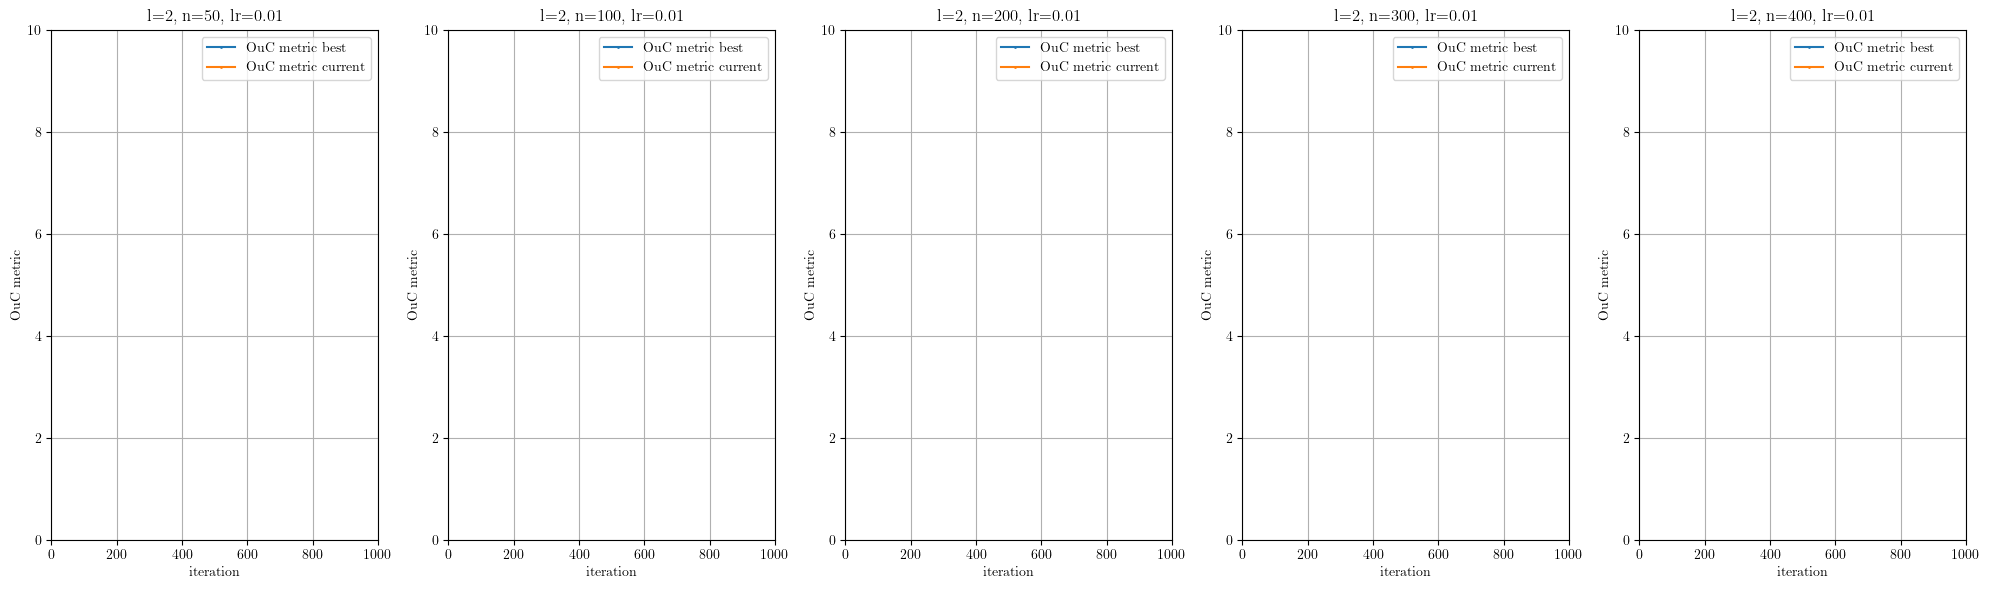

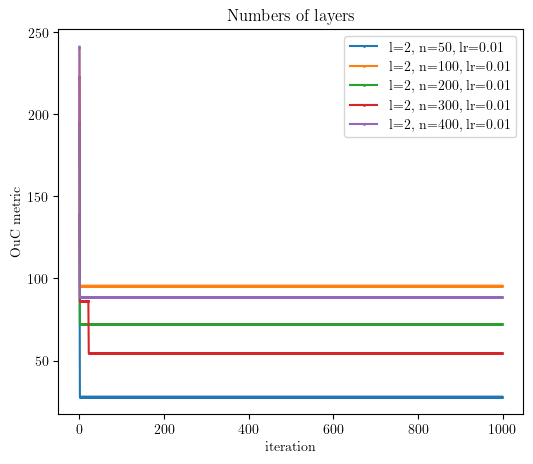

In [24]:
res_neurons = try_neurons([50, 100, 200, 300, 400], 2, 0.01)
plot_results(res_neurons, y_max=10)
plot_result_confrontation(res_neurons)

LAYERS: 2 NEURONS: 100 LR: 0.0001 epsilon: 65.24397 MSE solution: 8.567534719544534 time: 134.4062521457672
LAYERS: 2 NEURONS: 100 LR: 0.001 epsilon: 85.77666 MSE solution: 8.655568639091316 time: 136.03447365760803
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 70.28078 MSE solution: 5.023813916061298 time: 134.4617908000946
LAYERS: 2 NEURONS: 100 LR: 0.1 epsilon: 34.62375 MSE solution: 5.121870299015509 time: 137.94233536720276


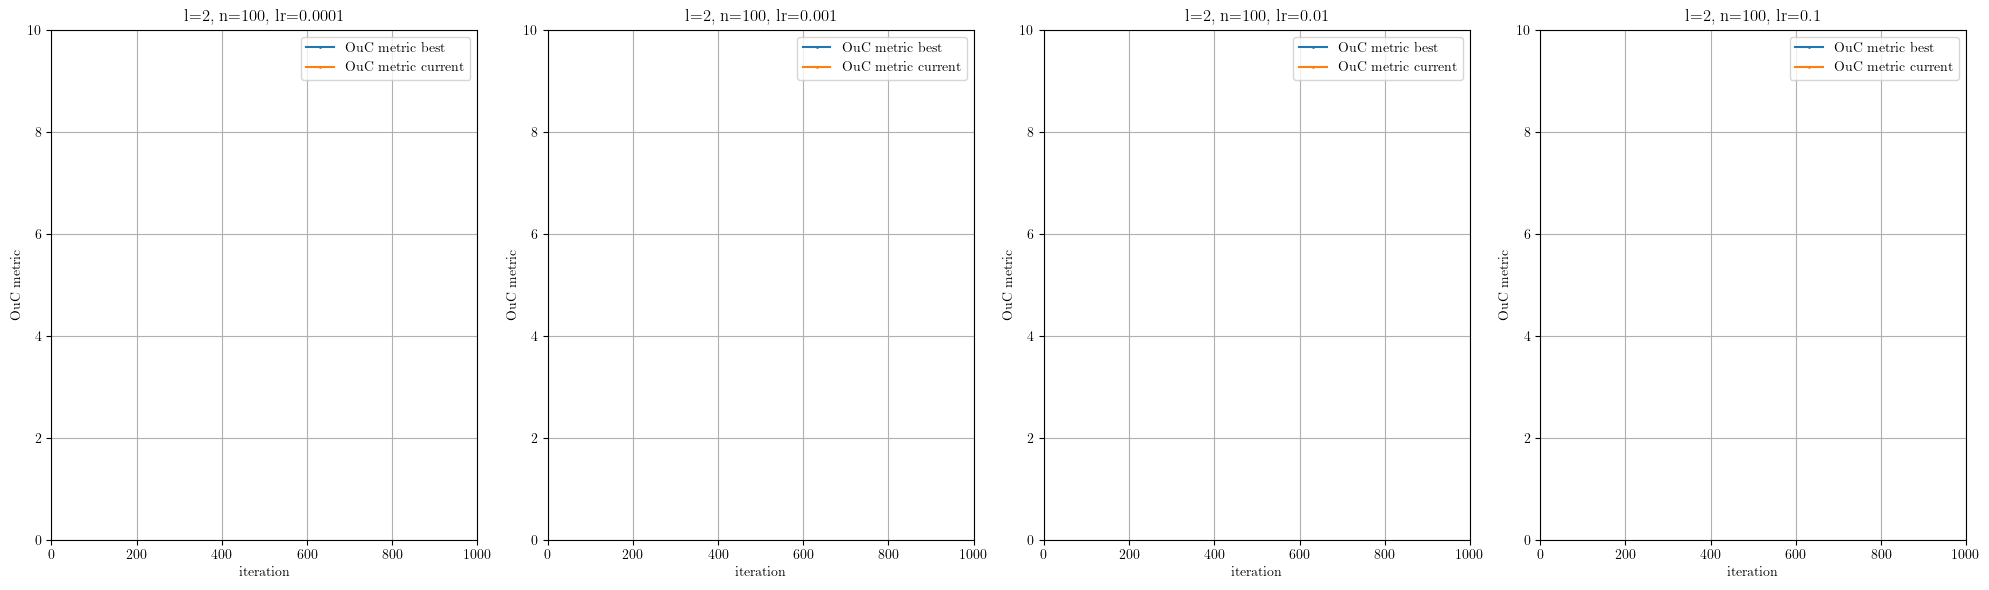

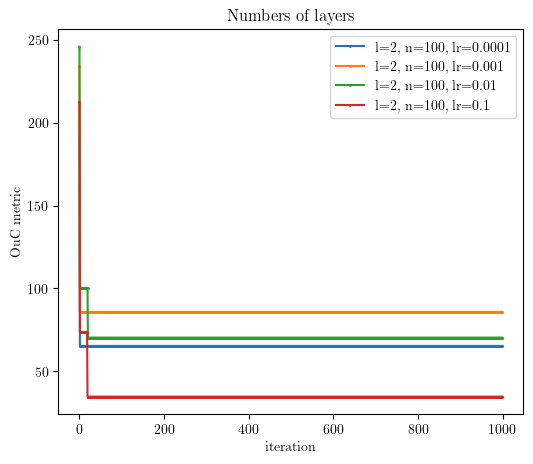

In [25]:
res_learning_rate = try_lr([0.0001, 0.001, 0.01, 0.1], 2, 100)
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

Weight vector w: [-7.10381963 -5.11616603]
Bias term b: -2.575717417130363e-15
Number of support vectors: 20


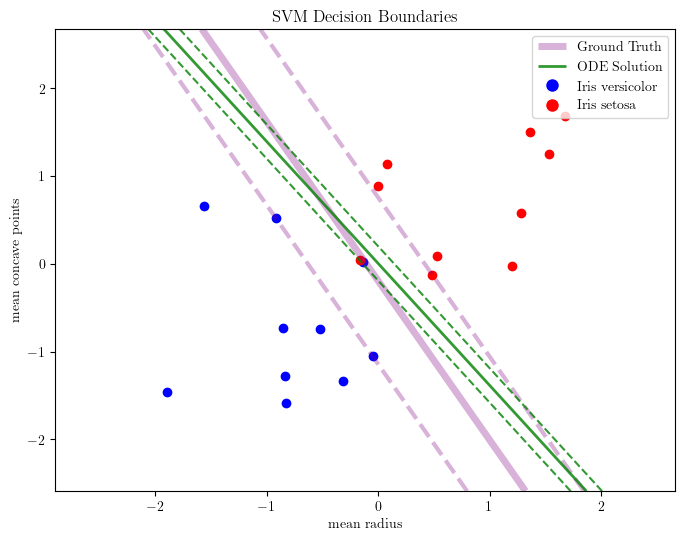

Variables: [0.4617179  0.4473834  0.34112775 0.09461379 0.43145168 0.57755196
 0.17513376 0.82829547 1.418727   0.4712783  0.5366057  0.27706397
 0.3514334  0.390202   0.31874865 0.17969513 0.66828626 0.8252603
 0.0659163  0.71764743]
Constraints: [-0.4617179  -0.4473834  -0.34112775 -0.09461379 -0.43145168 -0.57755196
 -0.17513376 -0.82829547 -1.418727   -0.4712783  -0.5366057  -0.27706397
 -0.3514334  -0.390202   -0.31874865 -0.17969513 -0.66828626 -0.8252603
 -0.0659163  -0.71764743 -9.538282   -9.552616   -9.658873   -9.905386
 -9.568548   -9.422448   -9.824866   -9.171704   -8.581273   -9.528722
 -9.463394   -9.722936   -9.648566   -9.609798   -9.681252   -9.820305
 -9.331714   -9.17474    -9.934084   -9.282352  ]


In [25]:
net = res_layers[1]['net']
res = net(torch.tensor([T]).cuda()).cpu().detach().numpy()

w_pinn, b_pinn, sv_pinn = alpha_to_wb(res[:nx], selected_X, selected_y)

print(f"Weight vector w: {w_pinn}")
print(f"Bias term b: {b_pinn}")
print(f"Number of support vectors: {np.sum(sv_pinn)}")

plot_svm_decision_boundary_confrontation(selected_X, selected_y, w_ode, b_ode, w_pinn, b_pinn, 0, 1)
print('Variables:', res[:nx])
print('Constraints:', g(res[:nx]))

Weight vector w: [-7.03902887 -5.04969974]
Bias term b: -2.042810365310288e-15
Number of support vectors: 20


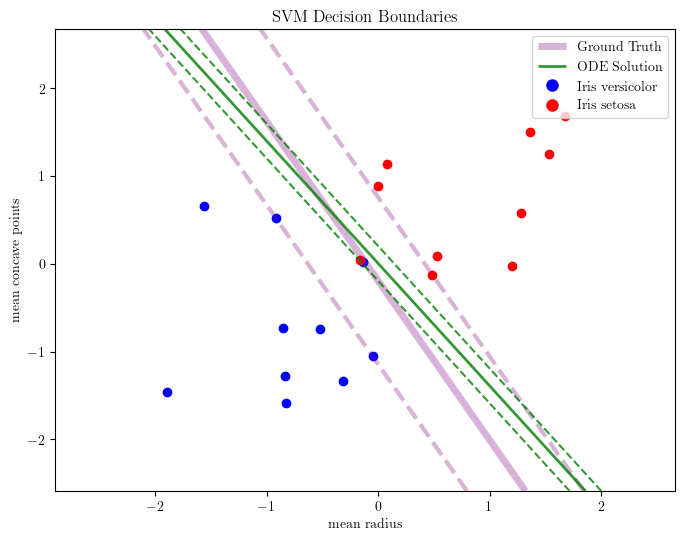

Variables: [0.45874614 0.44196582 0.33568692 0.089728   0.42659724 0.5728688
 0.16973174 0.824314   1.4187889  0.46640766 0.53184915 0.27411723
 0.35135233 0.3853947  0.3139271  0.1743412  0.66525507 0.82042515
 0.0611757  0.7145275 ]
Constraints: [-0.45874614 -0.44196582 -0.33568692 -0.089728   -0.42659724 -0.5728688
 -0.16973174 -0.824314   -1.4187889  -0.46640766 -0.53184915 -0.27411723
 -0.35135233 -0.3853947  -0.3139271  -0.1743412  -0.66525507 -0.82042515
 -0.0611757  -0.7145275  -9.541254   -9.558034   -9.664313   -9.910272
 -9.573402   -9.427132   -9.830268   -9.175686   -8.581211   -9.533592
 -9.468151   -9.725883   -9.648647   -9.614605   -9.686073   -9.825659
 -9.334745   -9.179575   -9.938825   -9.285473  ]


In [27]:
net = res_neurons[0]['net']
res = net(torch.tensor([T]).cuda()).cpu().detach().numpy()

w_pinn, b_pinn, sv_pinn = alpha_to_wb(res[:nx], selected_X, selected_y)

print(f"Weight vector w: {w_pinn}")
print(f"Bias term b: {b_pinn}")
print(f"Number of support vectors: {np.sum(sv_pinn)}")

plot_svm_decision_boundary_confrontation(selected_X, selected_y, w_ode, b_ode, w_pinn, b_pinn, 0, 1)
print('Variables:', res[:nx])
print('Constraints:', g(res[:nx]))

Weight vector w: [-9.12548611 -4.45800041]
Bias term b: -0.24836757070063323
Number of support vectors: 19


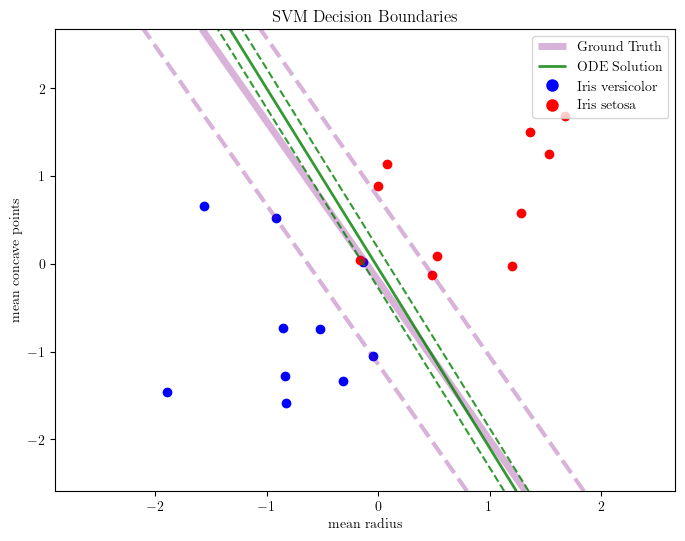

Variables: [ 1.154064    1.0862868   0.4564979   0.50529474  0.53990304  0.6399226
 -0.00792813  4.64124     1.901464    0.31021708  0.34947932  0.48065192
  1.7212853   0.44999534  0.36814976  0.5363142   0.38276893  0.07861859
  0.3298667   1.0263011 ]
Constraints: [ -1.154064    -1.0862868   -0.4564979   -0.50529474  -0.53990304
  -0.6399226    0.00792813  -4.64124     -1.901464    -0.31021708
  -0.34947932  -0.48065192  -1.7212853   -0.44999534  -0.36814976
  -0.5363142   -0.38276893  -0.07861859  -0.3298667   -1.0263011
  -8.845936    -8.913713    -9.543502    -9.494705    -9.460097
  -9.360077   -10.007928    -5.35876     -8.098536    -9.689783
  -9.65052     -9.519348    -8.278715    -9.550005    -9.63185
  -9.463686    -9.617231    -9.921381    -9.670134    -8.973699  ]


In [28]:
net = res_learning_rate[3]['net']
res = net(torch.tensor([T]).cuda()).cpu().detach().numpy()

w_pinn, b_pinn, sv_pinn = alpha_to_wb(res[:nx], selected_X, selected_y)

print(f"Weight vector w: {w_pinn}")
print(f"Bias term b: {b_pinn}")
print(f"Number of support vectors: {np.sum(sv_pinn)}")

plot_svm_decision_boundary_confrontation(selected_X, selected_y, w_ode, b_ode, w_pinn, b_pinn, 0, 1)
print('Variables:', res[:nx])
print('Constraints:', g(res[:nx]))

In [29]:
LAYERS = 2
NEURONS = 100
LR = 0.01
import time
example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, t = example.NN_method() # train
mse_ = get_error({'net': net_best})
print('LAYERS:', LAYERS, 'NEURONS:', NEURONS, 'LR:', LR, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', t)
res = {'layers': LAYERS, 'neurons': NEURONS, 'lr': LR, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time}

LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 76.19805 MSE solution: 4.965039524188968 time: 143.04418206214905


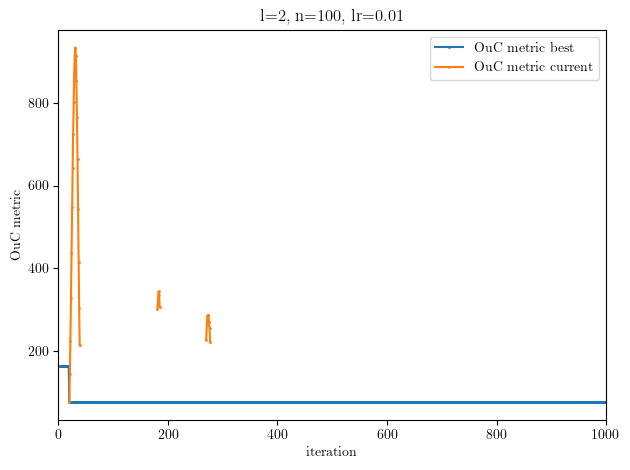

In [30]:
plt.plot(res['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
plt.plot(res['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
plt.xlabel('iteration')
plt.ylabel('OuC metric')
plt.title(f'l={res["layers"]}, n={res["neurons"]}, lr={res["lr"]}')
plt.legend()
plt.grid(False)
#plt.set_ylim(y_min, y_max)
plt.xlim(0, ITERATIONS)

plt.tight_layout()
# Show the plot
plt.show()

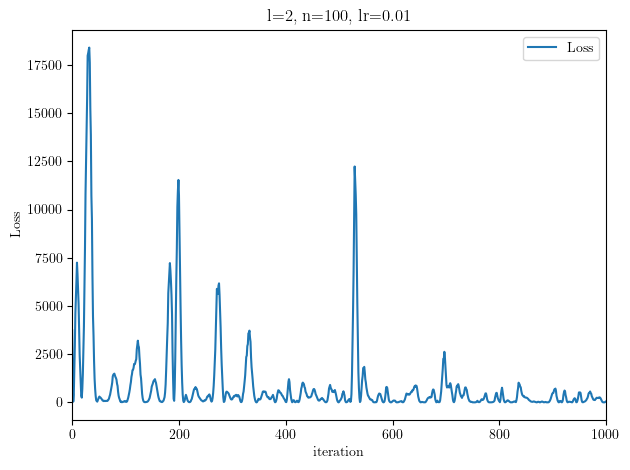

In [31]:
plt.plot(L_loss, label='Loss')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.title(f'l={res["layers"]}, n={res["neurons"]}, lr={res["lr"]}')
plt.legend()
plt.grid(False)
#plt.set_ylim(y_min, y_max)
plt.xlim(0, ITERATIONS)
plt.tight_layout()
# Show the plot
plt.show()

Weight vector w: [-11.60722701  -8.00745811]
Bias term b: -1.406477275635215
Number of support vectors: 19


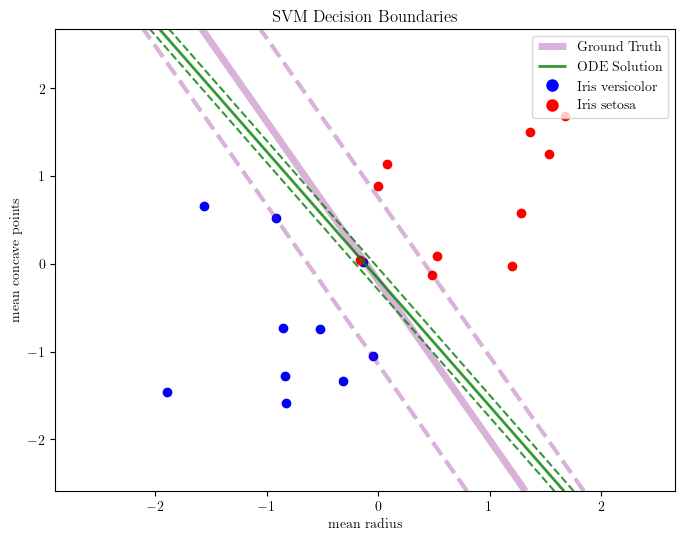

Variables: [ 0.8756924   1.5726256   1.1968046   0.9007499   0.74420476  1.6507506
  0.9786114   4.2836576   2.6505594   0.2912315   0.86596376  0.39133823
  1.7336857   1.0551606   0.68513846  1.1521434   0.94276077  0.11120057
 -0.15024781  1.2934946 ]
Constraints: [ -0.8756924   -1.5726256   -1.1968046   -0.9007499   -0.74420476
  -1.6507506   -0.9786114   -4.2836576   -2.6505594   -0.2912315
  -0.86596376  -0.39133823  -1.7336857   -1.0551606   -0.68513846
  -1.1521434   -0.94276077  -0.11120057   0.15024781  -1.2934946
  -9.124308    -8.427374    -8.803195    -9.09925     -9.2557955
  -8.349249    -9.021389    -5.7163424   -7.3494406   -9.708769
  -9.134036    -9.608662    -8.2663145   -8.9448395   -9.314861
  -8.8478565   -9.05724     -9.8888     -10.150248    -8.706506  ]


In [32]:
net = res['net']
res_ = net(torch.tensor([T]).cuda()).cpu().detach().numpy()

w_pinn, b_pinn, sv_pinn = alpha_to_wb(res_[:nx], selected_X, selected_y)

print(f"Weight vector w: {w_pinn}")
print(f"Bias term b: {b_pinn}")
print(f"Number of support vectors: {np.sum(sv_pinn)}")

plot_svm_decision_boundary_confrontation(selected_X, selected_y, w_ode, b_ode, w_pinn, b_pinn, 0, 1)

print('Variables:', res_[:nx])
print('Constraints:', g(res_[:nx]))